In [1]:
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=0,1

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=0,1


In [2]:
import torch
from pytorch_pretrained_biggan import (
    BigGAN, 
    one_hot_from_int, 
    truncated_noise_sample)
import time
import torchvision.utils as vutils
import torch.optim as optim
import torch.nn as nn
from PIL import Image
import numpy as np
import IPython.display
import cv2
# from simclr_transforms import tx
# from simclr_transforms import RandomResizedCrop

In [ ]:
import io
import PIL

def imshow(a, format='png', jpeg_fallback=True, filename=None):
  a = np.asarray(a, dtype=np.uint8)
  str_file = io.BytesIO()
  PIL.Image.fromarray(a).save(str_file, format)
  im_data = str_file.getvalue()
  try:
    disp = IPython.display.display(IPython.display.Image(im_data))
    if filename:
        size = (a.shape[1]//2, a.shape[0]//2)
        im = PIL.Image.fromarray(a)
        im.thumbnail(size,PIL.Image.ANTIALIAS)
        im.save('{}.{}'.format(filename, format))
        
  except IOError:
    if jpeg_fallback and format != 'jpeg':
      print ('Warning: image was too large to display in format "{}"; '
             'trying jpeg instead.').format(format)
      return imshow(a, format='jpeg')
    else:
      raise
  return disp

def imshow_unscaled(target, return_img=False):
  np_target = target
  np_target_scaled = np.clip(((np_target + 1) / 2.0) * 256, 0, 255)
  im = np.concatenate(np_target_scaled, axis=0)
  imshow(np.uint8(im))
  if return_img:
      return im

In [116]:
import math
import numbers
import random
import warnings
from collections.abc import Sequence
from typing import Tuple, List, Optional

import torch
from PIL import Image
from torch import Tensor

try:
    import accimage
except ImportError:
    accimage = None

# from . import functional as F
import torchvision.transforms.functional as F

_pil_interpolation_to_str = {
    Image.NEAREST: 'PIL.Image.NEAREST',
    Image.BILINEAR: 'PIL.Image.BILINEAR',
    Image.BICUBIC: 'PIL.Image.BICUBIC',
    Image.LANCZOS: 'PIL.Image.LANCZOS',
    Image.HAMMING: 'PIL.Image.HAMMING',
    Image.BOX: 'PIL.Image.BOX',
}


class Compose:
    """Composes several transforms together. This transform does not support torchscript.
    Please, see the note below.

    Args:
        transforms (list of ``Transform`` objects): list of transforms to compose.

    Example:
        >>> transforms.Compose([
        >>>     transforms.CenterCrop(10),
        >>>     transforms.ToTensor(),
        >>> ])

    .. note::
        In order to script the transformations, please use ``torch.nn.Sequential`` as below.

        >>> transforms = torch.nn.Sequential(
        >>>     transforms.CenterCrop(10),
        >>>     transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
        >>> )
        >>> scripted_transforms = torch.jit.script(transforms)

        Make sure to use only scriptable transformations, i.e. that work with ``torch.Tensor``, does not require
        `lambda` functions or ``PIL.Image``.

    """

    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, img):
        for t in self.transforms:
            img = t(img)
        return img

    def __repr__(self):
        format_string = self.__class__.__name__ + '('
        for t in self.transforms:
            format_string += '\n'
            format_string += '    {0}'.format(t)
        format_string += '\n)'
        return format_string


class Lambda:
    """Apply a user-defined lambda as a transform. This transform does not support torchscript.

    Args:
        lambd (function): Lambda/function to be used for transform.
    """

    def __init__(self, lambd):
        if not callable(lambd):
            raise TypeError("Argument lambd should be callable, got {}".format(repr(type(lambd).__name__)))
        self.lambd = lambd

    def __call__(self, img):
        return self.lambd(img)

    def __repr__(self):
        return self.__class__.__name__ + '()'

    
class ToPILImage:
    """Convert a tensor or an ndarray to PIL Image. This transform does not support torchscript.

    Converts a torch.*Tensor of shape C x H x W or a numpy ndarray of shape
    H x W x C to a PIL Image while preserving the value range.

    Args:
        mode (`PIL.Image mode`_): color space and pixel depth of input data (optional).
            If ``mode`` is ``None`` (default) there are some assumptions made about the input data:
            - If the input has 4 channels, the ``mode`` is assumed to be ``RGBA``.
            - If the input has 3 channels, the ``mode`` is assumed to be ``RGB``.
            - If the input has 2 channels, the ``mode`` is assumed to be ``LA``.
            - If the input has 1 channel, the ``mode`` is determined by the data type (i.e ``int``, ``float``,
            ``short``).

    .. _PIL.Image mode: https://pillow.readthedocs.io/en/latest/handbook/concepts.html#concept-modes
    """
    def __init__(self, mode=None):
        self.mode = mode

    def __call__(self, pic):
        """
        Args:
            pic (Tensor or numpy.ndarray): Image to be converted to PIL Image.

        Returns:
            PIL Image: Image converted to PIL Image.

        """
        return F.to_pil_image(pic, self.mode)

    def __repr__(self):
        format_string = self.__class__.__name__ + '('
        if self.mode is not None:
            format_string += 'mode={0}'.format(self.mode)
        format_string += ')'
        return format_string
    
    
class RandomHorizontalFlip(torch.nn.Module):
    """Horizontally flip the given image randomly with a given probability.
    The image can be a PIL Image or a torch Tensor, in which case it is expected
    to have [..., H, W] shape, where ... means an arbitrary number of leading
    dimensions

    Args:
        p (float): probability of the image being flipped. Default value is 0.5
    """

    def __init__(self, p=0.5):
        super().__init__()
        self.p = p

    def forward(self, img):
        """
        Args:
            img (PIL Image or Tensor): Image to be flipped.

        Returns:
            PIL Image or Tensor: Randomly flipped image.
        """
        if torch.rand(1) < self.p:
            return F.hflip(img)
        return img


    def __repr__(self):
        return self.__class__.__name__ + '(p={})'.format(self.p)


class RandomResizedCrop(torch.nn.Module):
    """Crop the given image to random size and aspect ratio.
    The image can be a PIL Image or a Tensor, in which case it is expected
    to have [..., H, W] shape, where ... means an arbitrary number of leading dimensions

    A crop of random size (default: of 0.08 to 1.0) of the original size and a random
    aspect ratio (default: of 3/4 to 4/3) of the original aspect ratio is made. This crop
    is finally resized to given size.
    This is popularly used to train the Inception networks.

    Args:
        size (int or sequence): expected output size of each edge. If size is an
            int instead of sequence like (h, w), a square output size ``(size, size)`` is
            made. If provided a tuple or list of length 1, it will be interpreted as (size[0], size[0]).
        scale (tuple of float): range of size of the origin size cropped
        ratio (tuple of float): range of aspect ratio of the origin aspect ratio cropped.
        interpolation (int): Desired interpolation enum defined by `filters`_.
            Default is ``PIL.Image.BILINEAR``. If input is Tensor, only ``PIL.Image.NEAREST``, ``PIL.Image.BILINEAR``
            and ``PIL.Image.BICUBIC`` are supported.
    """

    def __init__(self, size, scale=(0.08, 1.0), ratio=(3. / 4., 4. / 3.), interpolation=Image.BILINEAR):
        super().__init__()
        self.size = _setup_size(size, error_msg="Please provide only two dimensions (h, w) for size.")

        if not isinstance(scale, Sequence):
            raise TypeError("Scale should be a sequence")
        if not isinstance(ratio, Sequence):
            raise TypeError("Ratio should be a sequence")
        if (scale[0] > scale[1]) or (ratio[0] > ratio[1]):
            warnings.warn("Scale and ratio should be of kind (min, max)")

        self.interpolation = interpolation
        self.scale = scale
        self.ratio = ratio

    @staticmethod
    def get_params(
            img: Tensor, scale: List[float], ratio: List[float]
    ) -> Tuple[int, int, int, int]:
        """Get parameters for ``crop`` for a random sized crop.

        Args:
            img (PIL Image or Tensor): Input image.
            scale (list): range of scale of the origin size cropped
            ratio (list): range of aspect ratio of the origin aspect ratio cropped

        Returns:
            tuple: params (i, j, h, w) to be passed to ``crop`` for a random
                sized crop.
        """
#         width, height = F._get_image_size(img)
        width, height = 256, 256
        area = height * width

        for _ in range(10):
            target_area = area * torch.empty(1).uniform_(scale[0], scale[1]).item()
            log_ratio = torch.log(torch.tensor(ratio))
            aspect_ratio = torch.exp(
                torch.empty(1).uniform_(log_ratio[0], log_ratio[1])
            ).item()

            w = int(round(math.sqrt(target_area * aspect_ratio)))
            h = int(round(math.sqrt(target_area / aspect_ratio)))

            if 0 < w <= width and 0 < h <= height:
                i = torch.randint(0, height - h + 1, size=(1,)).item()
                j = torch.randint(0, width - w + 1, size=(1,)).item()
                return i, j, h, w

        # Fallback to central crop
        in_ratio = float(width) / float(height)
        if in_ratio < min(ratio):
            w = width
            h = int(round(w / min(ratio)))
        elif in_ratio > max(ratio):
            h = height
            w = int(round(h * max(ratio)))
        else:  # whole image
            w = width
            h = height
        i = (height - h) // 2
        j = (width - w) // 2
        return i, j, h, w


    def forward(self, img):
        """
        Args:
            img (PIL Image or Tensor): Image to be cropped and resized.

        Returns:
            PIL Image or Tensor: Randomly cropped and resized image.
        """
        i, j, h, w = self.get_params(img, self.scale, self.ratio)
        return F.resized_crop(img, i, j, h, w, self.size, self.interpolation), [i, j, h, w]


    def __repr__(self):
        interpolate_str = _pil_interpolation_to_str[self.interpolation]
        format_string = self.__class__.__name__ + '(size={0}'.format(self.size)
        format_string += ', scale={0}'.format(tuple(round(s, 4) for s in self.scale))
        format_string += ', ratio={0}'.format(tuple(round(r, 4) for r in self.ratio))
        format_string += ', interpolation={0})'.format(interpolate_str)
        return format_string


class ColorJitter(torch.nn.Module):
    """Randomly change the brightness, contrast and saturation of an image.

    Args:
        brightness (float or tuple of float (min, max)): How much to jitter brightness.
            brightness_factor is chosen uniformly from [max(0, 1 - brightness), 1 + brightness]
            or the given [min, max]. Should be non negative numbers.
        contrast (float or tuple of float (min, max)): How much to jitter contrast.
            contrast_factor is chosen uniformly from [max(0, 1 - contrast), 1 + contrast]
            or the given [min, max]. Should be non negative numbers.
        saturation (float or tuple of float (min, max)): How much to jitter saturation.
            saturation_factor is chosen uniformly from [max(0, 1 - saturation), 1 + saturation]
            or the given [min, max]. Should be non negative numbers.
        hue (float or tuple of float (min, max)): How much to jitter hue.
            hue_factor is chosen uniformly from [-hue, hue] or the given [min, max].
            Should have 0<= hue <= 0.5 or -0.5 <= min <= max <= 0.5.
    """

    def __init__(self, brightness=0, contrast=0, saturation=0, hue=0):
        super().__init__()
        self.brightness = self._check_input(brightness, 'brightness')
        self.contrast = self._check_input(contrast, 'contrast')
        self.saturation = self._check_input(saturation, 'saturation')
        self.hue = self._check_input(hue, 'hue', center=0, bound=(-0.5, 0.5),
                                     clip_first_on_zero=False)

    @torch.jit.unused
    def _check_input(self, value, name, center=1, bound=(0, float('inf')), clip_first_on_zero=True):
        if isinstance(value, numbers.Number):
            if value < 0:
                raise ValueError("If {} is a single number, it must be non negative.".format(name))
            value = [center - float(value), center + float(value)]
            if clip_first_on_zero:
                value[0] = max(value[0], 0.0)
        elif isinstance(value, (tuple, list)) and len(value) == 2:
            if not bound[0] <= value[0] <= value[1] <= bound[1]:
                raise ValueError("{} values should be between {}".format(name, bound))
        else:
            raise TypeError("{} should be a single number or a list/tuple with lenght 2.".format(name))

        # if value is 0 or (1., 1.) for brightness/contrast/saturation
        # or (0., 0.) for hue, do nothing
        if value[0] == value[1] == center:
            value = None
        return value

    @staticmethod
    @torch.jit.unused
    def get_params(brightness, contrast, saturation, hue):
        """Get a randomized transform to be applied on image.

        Arguments are same as that of __init__.

        Returns:
            Transform which randomly adjusts brightness, contrast and
            saturation in a random order.
        """
        transforms = []

        if brightness is not None:
            brightness_factor = random.uniform(brightness[0], brightness[1])
            transforms.append(Lambda(lambda img: F.adjust_brightness(img, brightness_factor)))

        if contrast is not None:
            contrast_factor = random.uniform(contrast[0], contrast[1])
            transforms.append(Lambda(lambda img: F.adjust_contrast(img, contrast_factor)))

        if saturation is not None:
            saturation_factor = random.uniform(saturation[0], saturation[1])
            transforms.append(Lambda(lambda img: F.adjust_saturation(img, saturation_factor)))

        if hue is not None:
            hue_factor = random.uniform(hue[0], hue[1])
            transforms.append(Lambda(lambda img: F.adjust_hue(img, hue_factor)))

        random.shuffle(transforms)
        transform = Compose(transforms)

        return transform


    def forward(self, img):
        """
        Args:
            img (PIL Image or Tensor): Input image.

        Returns:
            PIL Image or Tensor: Color jittered image.
        """
        fn_idx = torch.randperm(4)
        fn_id_array = torch.zeros(4, dtype=torch.float32)

        for fn_id in fn_idx:
            if fn_id == 0 and self.brightness is not None:
                brightness = self.brightness
                brightness_factor = torch.tensor(1.0).uniform_(brightness[0], brightness[1]).item()
#                 img = F.adjust_brightness(img, brightness_factor)
                fn_id_array[fn_id] = brightness_factor

            if fn_id == 1 and self.contrast is not None:
                contrast = self.contrast
                contrast_factor = torch.tensor(1.0).uniform_(contrast[0], contrast[1]).item()
#                 img = F.adjust_contrast(img, contrast_factor)
                fn_id_array[fn_id] = contrast_factor

            if fn_id == 2 and self.saturation is not None:
                saturation = self.saturation
                saturation_factor = torch.tensor(1.0).uniform_(saturation[0], saturation[1]).item()
#                 img = F.adjust_saturation(img, saturation_factor)
                fn_id_array[fn_id] = saturation_factor

            if fn_id == 3 and self.hue is not None:
                hue = self.hue
                hue_factor = torch.tensor(1.0).uniform_(hue[0], hue[1]).item()
                img = F.adjust_hue(img, hue_factor)
                fn_id_array[fn_id] = hue_factor
        
        return img, fn_id_array


    def __repr__(self):
        format_string = self.__class__.__name__ + '('
        format_string += 'brightness={0}'.format(self.brightness)
        format_string += ', contrast={0}'.format(self.contrast)
        format_string += ', saturation={0}'.format(self.saturation)
        format_string += ', hue={0})'.format(self.hue)
        return format_string




        """
        Args:
            img (PIL Image or Tensor): Image to be converted to grayscale.

        Returns:
            PIL Image or Tensor: Grayscaled image.
        """
        return F.rgb_to_grayscale(img, num_output_channels=self.num_output_channels)


    def __repr__(self):
        return self.__class__.__name__ + '(num_output_channels={0})'.format(self.num_output_channels)


class RandomGrayscale(torch.nn.Module):
    """Randomly convert image to grayscale with a probability of p (default 0.1).
    The image can be a PIL Image or a Tensor, in which case it is expected
    to have [..., 3, H, W] shape, where ... means an arbitrary number of leading
    dimensions

    Args:
        p (float): probability that image should be converted to grayscale.

    Returns:
        PIL Image or Tensor: Grayscale version of the input image with probability p and unchanged
        with probability (1-p).
        - If input image is 1 channel: grayscale version is 1 channel
        - If input image is 3 channel: grayscale version is 3 channel with r == g == b

    """

    def __init__(self, p=0.1):
        super().__init__()
        self.p = p

    def forward(self, img):
        """
        Args:
            img (PIL Image or Tensor): Image to be converted to grayscale.

        Returns:
            PIL Image or Tensor: Randomly grayscaled image.
        """
#         num_output_channels = F._get_image_num_channels(img)
        num_output_channels = 3
        if torch.rand(1) < self.p:
            return F.rgb_to_grayscale(img, num_output_channels=num_output_channels), 1
        return img, 0


    def __repr__(self):
        return self.__class__.__name__ + '(p={0})'.format(self.p)


def _setup_size(size, error_msg):
    if isinstance(size, numbers.Number):
        return int(size), int(size)

    if isinstance(size, Sequence) and len(size) == 1:
        return size[0], size[0]

    if len(size) != 2:
        raise ValueError(error_msg)

    return size


In [4]:
G = BigGAN.from_pretrained('biggan-deep-256')
if torch.cuda.device_count() > 1:
    print('Using {} gpus for G'.format(torch.cuda.device_count()))
    G = torch.nn.DataParallel(G)
G.to('cuda')

Using 2 gpus for G


DataParallel(
  (module): BigGAN(
    (embeddings): Linear(in_features=1000, out_features=128, bias=False)
    (generator): Generator(
      (gen_z): Linear(in_features=256, out_features=32768, bias=True)
      (layers): ModuleList(
        (0): GenBlock(
          (bn_0): BigGANBatchNorm(
            (scale): Linear(in_features=256, out_features=2048, bias=False)
            (offset): Linear(in_features=256, out_features=2048, bias=False)
          )
          (conv_0): Conv2d(2048, 512, kernel_size=(1, 1), stride=(1, 1))
          (bn_1): BigGANBatchNorm(
            (scale): Linear(in_features=256, out_features=512, bias=False)
            (offset): Linear(in_features=256, out_features=512, bias=False)
          )
          (conv_1): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (bn_2): BigGANBatchNorm(
            (scale): Linear(in_features=256, out_features=512, bias=False)
            (offset): Linear(in_features=256, out_features=512, bias=False)

In [117]:
def get_targets(out_im):
    out_im = out_im.cpu().numpy().transpose(0,2,3,1)
    out_im = np.clip(((out_im + 1.0) / 2.0) * 255, 0, 255)
    out_im = np.uint8(out_im)
    targets = np.zeros(out_im.shape)
    alphas_rrc = torch.zeros((out_im.shape[0], 4), dtype=torch.float32)
    alphas_jit = torch.zeros((out_im.shape[0], 4), dtype=torch.float32)
    for b in range(out_im.shape[0]):
        rrc, rrc_params = tx_rrc(Image.fromarray(out_im[b]))
        jit, jit_fn_array = tx_jit(Image.fromarray(out_im[b])) 
        targets[b] = jit
        alphas_jit[b,:] = jit_fn_array
        alphas_rrc[b,:] = torch.tensor(rrc_params, dtype=torch.float32)
    targets = ((torch.tensor(targets, dtype=torch.float32)/255 - 0.5) * 2.0).permute(0,3,1,2)
    return targets, alphas_jit, alphas_rrc

In [113]:
# training parameters
dim_z = truncated_noise_sample(truncation=0.1, batch_size=1).shape[1]
learning_rate = 0.001 # you can also try changing this as well
w_jit = torch.tensor(np.random.normal(0.0, 0.1, [1, dim_z, 4]),
                     device='cuda', dtype=torch.float32, requires_grad=True)

w_rrc = nn.Sequential(nn.Linear(dim_z+4, dim_z+4),
                      nn.ReLU(inplace=True),
                      nn.Linear(dim_z+4, dim_z)).to('cuda')
# loss function and optimizer
criterion = nn.MSELoss(reduction='sum')
# optimizer_rrc = optim.Adam(w_rrc.parameters(), lr=learning_rate)
# optimizer_jit = optim.Adam([w_jit], lr=learning_rate)
# optimizer = optim.Adam([w_jit] + [param for param in w_rrc.parameters()], lr=learning_rate)
optimizer = optim.Adam([w_jit], lr=learning_rate)

In [ ]:
## Lets check transformations
img_size = 256
# tx_rrc = RandomResizedCrop(size=int(img_size*0.875), scale=(0.2, 1.))
tx_rrc = RandomResizedCrop(size=int(img_size), scale=(0.2, 1.))
tx_jit = ColorJitter(0.4, 0.4, 0.4, 0.1)

truncation = 1.0
num_samples = 4
batch_size = num_samples

for batch_num in range(num_samples // batch_size):
    # latents
    zs = truncated_noise_sample(truncation=truncation, batch_size=batch_size, seed=None)
    zs = torch.from_numpy(zs).to('cuda')
    # labels
    ys = one_hot_from_int(np.random.choice(1000, batch_size), batch_size)
    ys = torch.from_numpy(ys).to('cuda')
    # sample images
    with torch.no_grad():
        out_im = G(zs, ys, truncation)

    # get targets and their alphas
    targets, alphas_jit, alphas_rrc = get_targets(out_im)

In [ ]:
print('G(z)')
image_grid = vutils.make_grid(out_im, nrow=batch_size, normalize=True)
image_grid_np = image_grid.cpu().numpy().transpose(1, 2, 0) * 255
image_grid_np = np.uint8(image_grid_np)
IPython.display.display(Image.fromarray(image_grid_np).resize(
    (image_grid_np.shape[1], image_grid_np.shape[0])))

print('Edit(G(z))')
image_grid = vutils.make_grid(targets, nrow=batch_size, normalize=True)
image_grid_np = image_grid.cpu().numpy().transpose(1, 2, 0) * 255
image_grid_np = np.uint8(image_grid_np)
IPython.display.display(Image.fromarray(image_grid_np).resize(
    (image_grid_np.shape[1], image_grid_np.shape[0])))

In [ ]:
# training
img_size = 256
# tx_rrc = RandomResizedCrop(size=int(img_size*0.875), scale=(0.2, 1.))
tx_rrc = RandomResizedCrop(size=int(img_size), scale=(0.2, 1.))
tx_jit = ColorJitter(0.4, 0.4, 0.4, 0.1)

num_samples = 200000
truncation = 1.0
loss_sum = 0
optim_iter = 0
batch_size = 32
loss_values = []
save_freq = 10000 # frequency to save weights

for batch_num in range(num_samples // batch_size):
    start_time = time.time()
    # latents
    zs = truncated_noise_sample(truncation=truncation, batch_size=batch_size, seed=None)
    zs = torch.from_numpy(zs).to('cuda')
    # labels
    ys = one_hot_from_int(np.random.choice(1000, batch_size), batch_size)
    ys = torch.from_numpy(ys).to('cuda')
    # sample images
    with torch.no_grad():
        out_im = G(zs, ys, truncation)

    # get targets and their alphas then to tensor
    targets, alphas_jit, alphas_rrc = get_targets(out_im)
    targets_tensor = targets.to('cuda')
    alphas_rrc_tensor = alphas_rrc.to('cuda')
    alphas_jit_tensor = alphas_jit.to('cuda')

    numel_masks_tensor = torch.tensor(img_size*img_size, device='cuda', dtype=torch.float32)

    # forward pass
#     optimizer_rrc.zero_grad()
#     optimizer_jit.zero_grad()
    optimizer.zero_grad()
    zs_new = zs #+ w_rrc(torch.cat((zs,alphas_rrc_tensor), 1))
    for c in range(4):
        if c < 3:
            zs_new = zs_new + torch.log(alphas_jit_tensor[:,0].unsqueeze(1)) * w_jit[:,:,c]
        else:
            zs_new = zs_new + alphas_jit_tensor[:,c].unsqueeze(1) * w_jit[:,:,c]

    out_im = G(zs_new, ys, truncation)
    # mean over unmasked regions in the target
    loss = criterion(out_im, targets_tensor) / numel_masks_tensor
  
    # 4. optimize loss 
    loss.backward()
#     optimizer_rrc.step()
#     optimizer_jit.step()
    optimizer.step()
    
    loss_values.append(loss)
    loss_sum += loss
    elapsed_time = time.time() - start_time
  
    print('Time:{}, batch_start:{}, loss:{}'.format(elapsed_time, batch_num * batch_size, loss))
 
    # save intermediate walk
    if (optim_iter % save_freq == 0) and (optim_iter > 0):
        torch.save({'walk_jit': w_jit, 'walk_rrc': w_rrc}, 
                   'walk_weights_biggan_deep/w_simclr_aug{}_hue_lr{}_N{}_1optim.pth'.format(optim_iter * batch_size, 
                                                                                 learning_rate, num_samples))
  
    optim_iter += 1
  
print('average loss with this metric: ', loss_sum/(optim_iter*batch_size))

final_ckpt_name = 'w_simclr_aug_hue_lr{}_N{}_1optim_final.pth'.format(learning_rate, num_samples)
torch.save({'walk_jit': w_jit, 'walk_rrc': w_rrc}, 
           'walk_weights_biggan_deep/{}'.format(final_ckpt_name))

with open('walk_weights_biggan_deep/{}_loss_values.pny'.format(final_ckpt_name), 'wb') as fid:
    np.save(fid, np.array(loss_values))



Loading pretrained walks...
G(z)


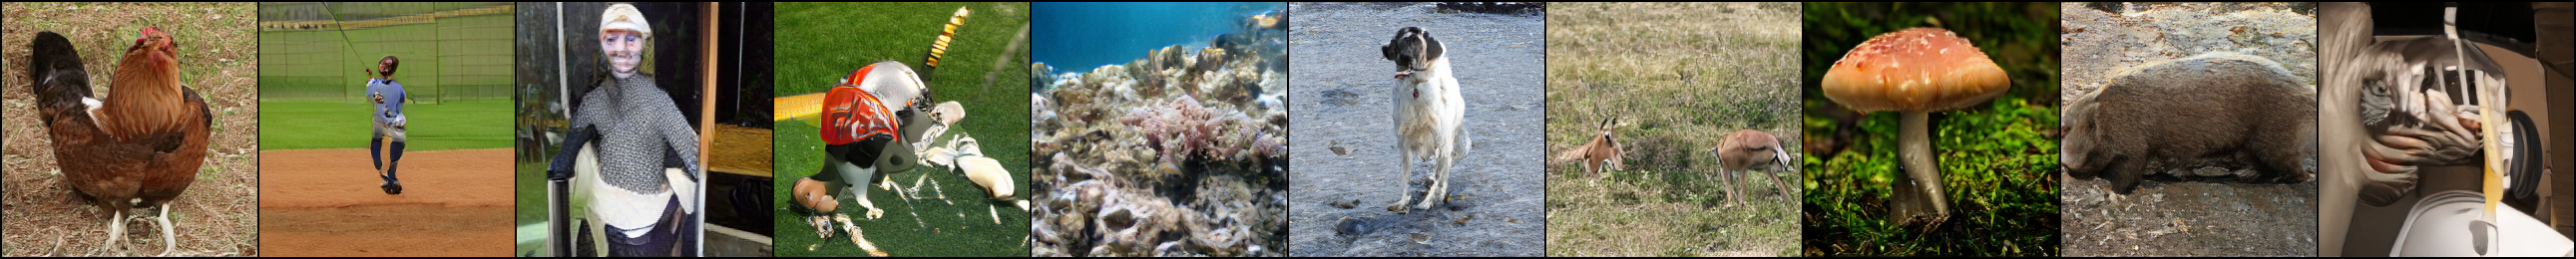

tensor([-0.1098, -0.0223,  0.2847], device='cuda:0') tensor(-0.0154, device='cuda:0')
tensor([ 0.2207, -0.2474, -0.3692], device='cuda:0') tensor(-0.0220, device='cuda:0')
tensor([ 1.8273e-04, -2.4618e-01,  2.9614e-01], device='cuda:0') tensor(-0.0791, device='cuda:0')
tensor([ 0.2129, -0.4177,  0.2624], device='cuda:0') tensor(0.0948, device='cuda:0')
tensor([ 0.2971, -0.0140, -0.2200], device='cuda:0') tensor(0.0363, device='cuda:0')
tensor([ 0.0773, -0.3077,  0.0785], device='cuda:0') tensor(0.0208, device='cuda:0')
tensor([-0.3379, -0.0646, -0.1268], device='cuda:0') tensor(-0.0241, device='cuda:0')
tensor([-0.1115, -0.1454,  0.0473], device='cuda:0') tensor(-0.0495, device='cuda:0')
tensor([-0.1781,  0.2630,  0.2231], device='cuda:0') tensor(-0.0257, device='cuda:0')
tensor([0.0605, 0.3144, 0.3211], device='cuda:0') tensor(0.0573, device='cuda:0')
Edit(G(z))


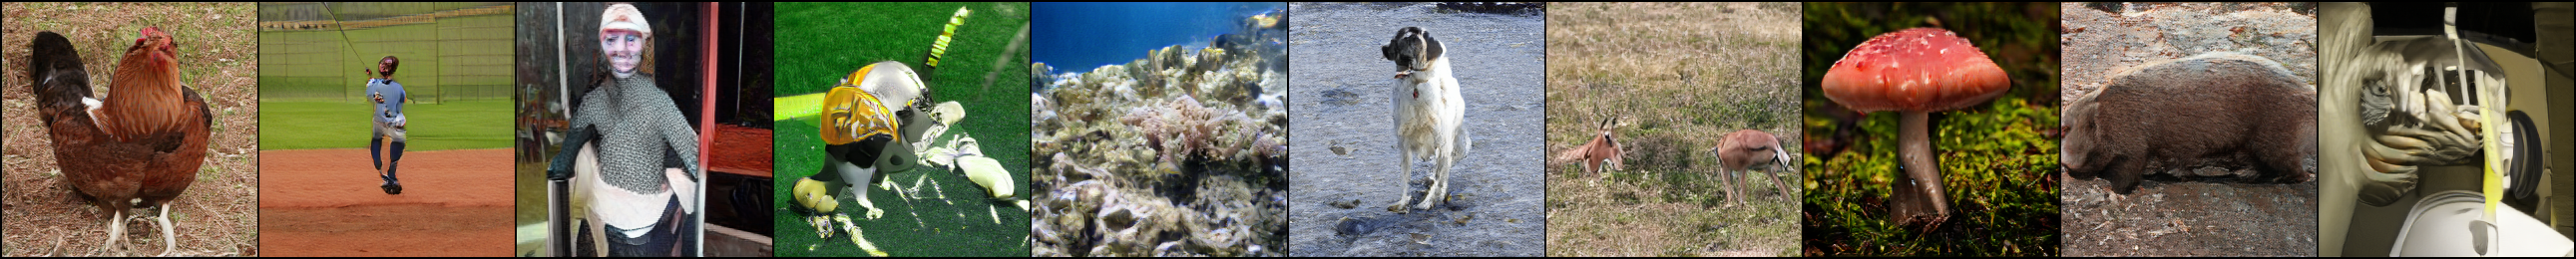

G(z+walks)


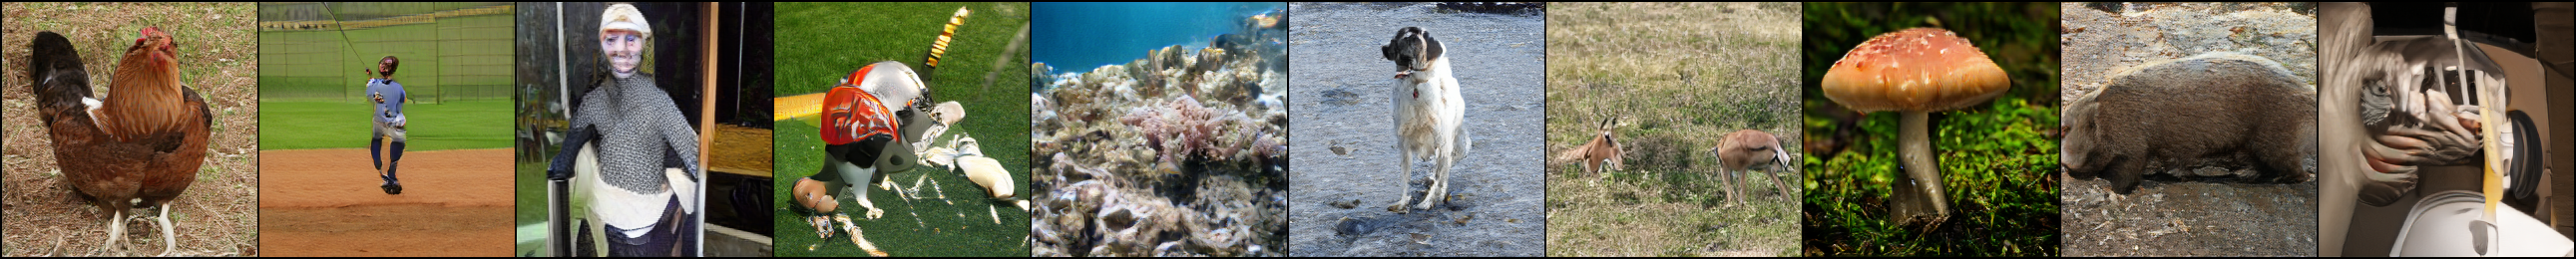

In [118]:
# test
print('Loading pretrained walks...')
walk_composed_final_path = ('./walk_weights_biggan_deep/w_simclr_aug_hue_lr0.002_N8000_1optim_final.pth')
walk_composed_final = torch.load(walk_composed_final_path)
w_rrc = walk_composed_final['walk_rrc'].to('cuda')
w_jit = walk_composed_final['walk_jit'].to('cuda')

img_size = 256
# tx_rrc = RandomResizedCrop(size=int(img_size*0.875), scale=(0.2, 1.))
tx_rrc = RandomResizedCrop(size=int(img_size), scale=(0.2, 1.))
tx_jit = ColorJitter(0.4, 0.4, 0.4, 0.1)

truncation = 1.0
num_samples = 10
batch_size = num_samples

for batch_num in range(num_samples // batch_size):
    # latents
    zs = truncated_noise_sample(truncation=truncation, batch_size=batch_size, seed=None)
    zs = torch.from_numpy(zs).to('cuda')
    # labels
    ys = one_hot_from_int(np.random.choice(1000, batch_size), batch_size)
    ys = torch.from_numpy(ys).to('cuda')
    # sample images
    with torch.no_grad():
        out_im = G(zs, ys, truncation)

    # get targets and their alphas
    targets, alphas_jit, alphas_rrc = get_targets(out_im)
    targets_tensor = targets.to('cuda')
    alphas_rrc_tensor = alphas_rrc.to('cuda')
    alphas_jit_tensor = alphas_jit.to('cuda')
    
    with torch.no_grad():
        zs_new = zs #+ w_rrc(torch.cat((zs,alphas_rrc_tensor), 1))
        zs_new = zs_new + alphas_jit_tensor[:,3].unsqueeze(1) * w_jit[:,:,0]

#         for c in range(4):
#             if c < 3:
#                 zs_new = zs_new + torch.log(alphas_jit_tensor[:,0].unsqueeze(1)) * w_jit[:,:,c]
#             else:
#                 zs_new = zs_new + 5*alphas_jit_tensor[:,c].unsqueeze(1) * w_jit[:,:,c]
        out_im_new = G(zs_new, ys, truncation)

            
    print('G(z)')
    image_grid = vutils.make_grid(out_im, nrow=batch_size, normalize=True)
    image_grid_np = image_grid.cpu().numpy().transpose(1, 2, 0) * 255
    image_grid_np = np.uint8(image_grid_np)
    IPython.display.display(Image.fromarray(image_grid_np).resize(
        (image_grid_np.shape[1], image_grid_np.shape[0])))

    for b in range(batch_size):
        print(torch.log(alphas_jit_tensor[b][0:3]),alphas_jit_tensor[b][3])
        
    print('Edit(G(z))')
    image_grid = vutils.make_grid(targets, nrow=batch_size, normalize=True)
    image_grid_np = image_grid.cpu().numpy().transpose(1, 2, 0) * 255
    image_grid_np = np.uint8(image_grid_np)
    IPython.display.display(Image.fromarray(image_grid_np).resize(
        (image_grid_np.shape[1], image_grid_np.shape[0])))
    
    print('G(z+walks)')
    image_grid = vutils.make_grid(out_im_new, nrow=batch_size, normalize=True)
    image_grid_np = image_grid.cpu().numpy().transpose(1, 2, 0) * 255
    image_grid_np = np.uint8(image_grid_np)
    IPython.display.display(Image.fromarray(image_grid_np).resize(
        (image_grid_np.shape[1], image_grid_np.shape[0])))

In [103]:
torch.log(alphas_jit_tensor[9][0:3]),alphas_jit_tensor[9][3] 

(tensor([ 0.0532, -0.1515,  0.1015], device='cuda:0'),
 tensor(-0.0433, device='cuda:0'))

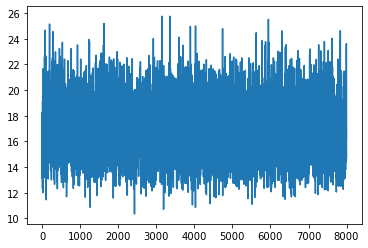

In [66]:
import matplotlib.pyplot as plt
with open('walk_weights_biggan_deep/w_simclr_aug_lr0.001_N320000_1optim_final.pth_loss_values.pny', 'rb') as fid:
    loss_values = np.load(fid, allow_pickle=True)
    
plt.plot(loss_values[2000:])

In [58]:
torch.log(alphas_jit_tensor[:,0].unsqueeze(1))

tensor([[ 0.0787],
        [-0.3362],
        [ 0.0522],
        [ 0.1684],
        [ 0.0564],
        [ 0.2576],
        [-0.1656],
        [ 0.2713],
        [-0.3789],
        [ 0.2066]], device='cuda:0')

In [57]:
alphas_jit_tensor[:,0].unsqueeze(1)

tensor([[1.0819],
        [0.7145],
        [1.0535],
        [1.1834],
        [1.0581],
        [1.2938],
        [0.8474],
        [1.3116],
        [0.6846],
        [1.2295]], device='cuda:0')

In [ ]:
def get_targets(out_im):
    out_im = out_im.cpu().numpy().transpose(0,2,3,1)
    out_im = np.clip(((out_im + 1.0) / 2.0) * 255, 0, 255)
    out_im = np.uint8(out_im)
    targets = np.zeros(out_im.shape)
    alphas_rrc = torch.zeros((out_im.shape[0], 4), dtype=torch.float32)
    alphas_jit = torch.zeros((out_im.shape[0], 4), dtype=torch.float32)
    for b in range(out_im.shape[0]):
        rrc, rrc_params = tx_rrc(Image.fromarray(out_im[b]))
        jit, jit_fn_array = tx_jit(rrc) 
        targets[b] = jit
        alphas_jit[b,:] = jit_fn_array
        alphas_rrc[b,:] = torch.tensor(rrc_params, dtype=torch.float32)
    targets = ((torch.tensor(targets, dtype=torch.float32)/255 - 0.5) * 2.0).permute(0,3,1,2)
    return targets, alphas_jit, alphas_rrc

# test
dim_z = 128
w_jit = torch.tensor(np.random.normal(0.0, 0.1, [1, dim_z, 4]),
                     device='cuda', dtype=torch.float32, requires_grad=True)

w_rrc = nn.Sequential(nn.Linear(dim_z+4, dim_z+4),
                      nn.ReLU(inplace=True),
                      nn.Linear(dim_z+4, dim_z)).to('cuda')

img_size = 256
# tx_rrc = RandomResizedCrop(size=int(img_size*0.875), scale=(0.2, 1.))
tx_rrc = RandomResizedCrop(size=int(img_size), scale=(0.2, 1.))
tx_jit = ColorJitter(0.4, 0.4, 0.4, 0.1)

truncation = 1.0
num_samples = 10
batch_size = num_samples

for batch_num in range(num_samples // batch_size):
    # latents
    zs = truncated_noise_sample(truncation=truncation, batch_size=batch_size, seed=None)
    zs = torch.from_numpy(zs).to('cuda')
    # labels
    ys = one_hot_from_int(np.random.choice(1000, batch_size), batch_size)
    ys = torch.from_numpy(ys).to('cuda')
    # sample images
    with torch.no_grad():
        out_im = G(zs, ys, truncation)

    # get targets and their alphas
    targets, alphas_jit, alphas_rrc = get_targets(out_im)
    targets_tensor = torch.tensor(targets, device='cuda', dtype=torch.float32)
    alphas_rrc_tensor = torch.tensor(alphas_rrc, device='cuda', dtype=torch.float32)
    alphas_jit_tensor = torch.tensor(alphas_jit, device='cuda', dtype=torch.float32)
    
    with torch.no_grad():
        zs_new = zs + w_rrc(torch.cat((zs,alphas_rrc_tensor), 1))
        for c in range(4):
            zs_new = zs_new + alphas_jit_tensor[:,c].unsqueeze(1) * w_jit[:,:,c]
        
        out_im_new = G(zs_new, ys, truncation)

    print('G(z)')
    image_grid = vutils.make_grid(out_im, nrow=batch_size, normalize=True)
    image_grid_np = image_grid.cpu().numpy().transpose(1, 2, 0) * 255
    image_grid_np = np.uint8(image_grid_np)
    IPython.display.display(Image.fromarray(image_grid_np).resize(
        (image_grid_np.shape[1], image_grid_np.shape[0])))
    
    print('Edit(G(z))')
    image_grid = vutils.make_grid(targets, nrow=batch_size, normalize=True)
    image_grid_np = image_grid.cpu().numpy().transpose(1, 2, 0) * 255
    image_grid_np = np.uint8(image_grid_np)
    IPython.display.display(Image.fromarray(image_grid_np).resize(
        (image_grid_np.shape[1], image_grid_np.shape[0])))
    
    print('G(z+walks)')
    image_grid = vutils.make_grid(out_im_new, nrow=batch_size, normalize=True)
    image_grid_np = image_grid.cpu().numpy().transpose(1, 2, 0) * 255
    image_grid_np = np.uint8(image_grid_np)
    IPython.display.display(Image.fromarray(image_grid_np).resize(
        (image_grid_np.shape[1], image_grid_np.shape[0])))

In [13]:
alphas_jit_tensor.shape

torch.Size([10, 4])

In [ ]:
alphas_jit